# Evaluation of the EPCOS/TDK B62152A0001X001 binocular core
It's not a cheap core at [€2.83/pce](https://www.trustedparts.com/en/part/tdk-electronics/B62152A0001X001), but the binocular core is :
* easier to mount on a PCB than a toroid core.
* takes less PCB area than a toroid.
* is easier to wind.  The windings stay in place more easily.  No tape needed.

The drawback is that only a limited number of winding options are available.  The 2:14 option is suitable for the 5MHz to 10MHz band, while the 1:7 option is suitable for the 15MHz to 30MHz band.

In [4]:
from calcInductors import calc_inductor_turns

# Epcos/TDK B62152A0001X001 (Siferrit K1 material)
# Double aperture (aka binocular core)
Al = 330 # [nH/N²]
Ae = 49.7e-6 # [m²]
d = 0.3e-3 # [m] wire diameter
ID = 3.4e-3 # [m] inside diameter
L = 1.33e-5 # [H] Minimum inductance for a 5x50ohm impedance at 3MHz
turns_ratio = 7

[Np, Ns] = calc_inductor_turns(Al, L, turns_ratio)
print("Required number of turns on primary winding: " + str(Np))
print("Required number of turns on secondary winding: " + str(Ns))


Required number of turns on primary winding: 7
Required number of turns on secondary winding: 49


# Circle packing problem
Use [WolframAlpha](https://www.wolframalpha.com/input?i=pack+circles+of+diameter+0.5mm+in+a+circle+of+diameter+3.4mm) to calculate how many times we can pass a wire through the core:
* ⌀0.5mm wire → 37 times, 80% filled fraction
* ⌀0.3mm wire → 105 times, 82% filled fraction

So far for the theory.  In practice, it took quite some effort to wind 16 windings (14 secondary + 2 primary) using ⌀0.5mm wire.  No effort will be made to even try winding a 3:21 transformer using the same wire and binocular core.

# 2:14 configuration

## Winding the core
<img src="./measurements/SIFERRIT/2p14s.jpg" alt="Picture of 4:28 transformer" width="1000"/>

In [5]:
N = 2
h = 14.5e-3 # [m]
c = 5.85e-3 # [m]

l = 2*(h+c)*N
print('About {:.3}m of wire is needed to wire {} windings.'.format(l, N))

About 0.0814m of wire is needed to wire 2 windings.


Real winding lengths are 58cm for 14 windings and 11cm for 2 windings.

1. Set your soldering iron to 410°C and check that you can solder the wire you'll be using for winding.
2. Wind the secondary coil first.
3. After finishing it, mark the start of the winding and write the number of turns onto the core.
4. Wind the primary coil, but start from the other side of the core.
5. Use the same winding direction as for the primary core.
6. After finishing the primary core: mark the start of the winding and the number of windings.

You could use a function generator and an oscilloscope afterwards to verify this.

# Measurement 1
1. Perform 1-Port calibration on the NanoVNA for 1023 datapoints, 50kHz to 10MHz (or another frequency that is higher than the self-resonant frequency).
2. Measure impedance of primary coil at 500kHz with secondary coil open and store the results in a Touchstone S1P-file.
3. Find the self-resonant frequency in the S1P-file on the right side of the Smith chart. (imaginary part of impedance is 0, resistance is maximum).
4. Measure impedance of primary coil at 500kHz with secondary coil shorted and store the results in a Touchstone S1P-file.

Then perform the calculations as demonstrated by [Gary Rondeau](https://squashpractice.com/2021/06/23/performance-of-491-ferrite-core-transformers/).



SRF = 8.219e+06Hz and the resistance is 6.325e+03Ω
Leakage inductance = 5.35e-08H
Magnetization inductance = 1.32e-06H
Al = 3.3e+02 nH/N²
Cw = 2.84e-10 F
Low frequency cut-off (fl) = 6.04e+06Hz
High frequency cut-off due to winding capacitance = 1.12e+07Hz
High frequency cut-off due to resonance of winding capacitance and leakage inductance = 4.08e+07Hz


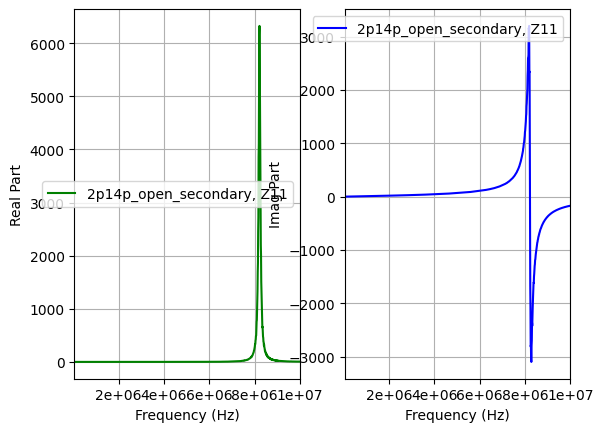

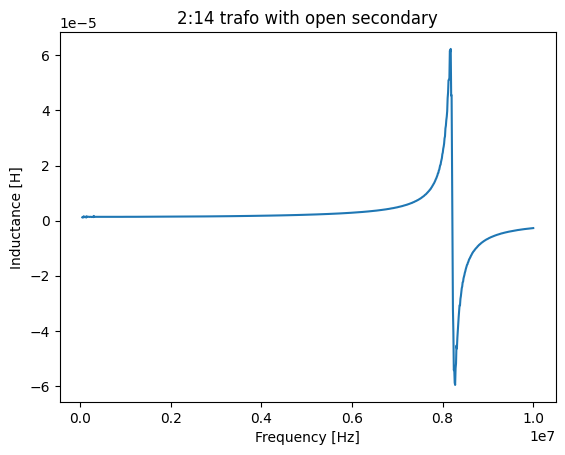

In [6]:
import skrf as rf
import math
import matplotlib.pyplot as plt
import numpy as np
from calcInductors import calcSRF, transformer_bandwidth_calculation
from plotResults import plot_impedance, plot_inductance

filepath = 'measurements/SIFERRIT/2p14p_open_secondary.s1p'
Zopen = 8.5e-3 + 4.31j
Zshorted = 17.5e-3 + 168e-3j

nw = rf.Network(filepath)
plot_impedance(nw)

srf = calcSRF(nw)
print('SRF = {:.4}Hz and the resistance is {:.4}Ω'.format(srf[1], srf[0]))

transformer_bandwidth_calculation(500e3, srf[1], 2, 50, Zopen, Zshorted)
# indexStart = 800
# indexStop = 820
# ntw = rf.Network(frequency=rf.Frequency.from_f(nw.f[indexStart:indexStop], unit='Hz'), s=nw.s[indexStart:indexStop])
# ntw.plot_z_re()
# ntw.plot_z_im()

plot_inductance(nw,'2:14 trafo with open secondary')

## Conclusion

Measured Al values is exactly the same value as given on the datasheet.
The measured winding capacity is 284pF, which is quite high.  It's not surprising because the windings are stacked very close together.

# Measurement 2
1. Perform 2-Port calibration on the NanoVNA for 1023 datapoints, 3MHz to 30MHz.
2. Perform the 2400Ω resistor calibration by connecting it between port 0 and port 1 as described in [trafo_matched_load](./trafo_matched_load.ipynb) and save the result as an Touchstone S2P-file.
  * S11 should be close to 0dB
  * S21 should be close to -28dB
3. Connect the primary winding to port 0.
4. Connect the secondary winding in series with a 2400Ω resistor to port 1.
5. Measure S11 and S21 using NanoSaver and export the results to a Touchstone S2P-file.

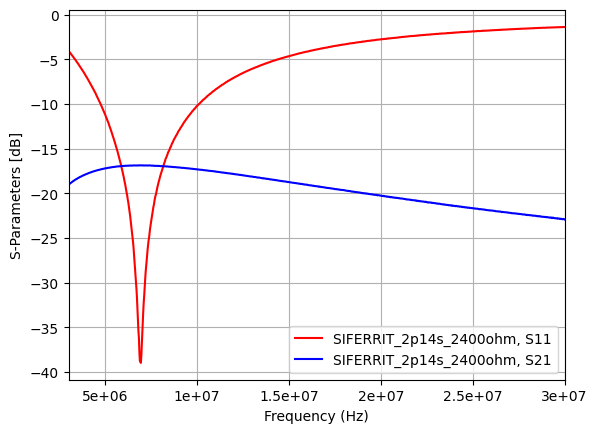

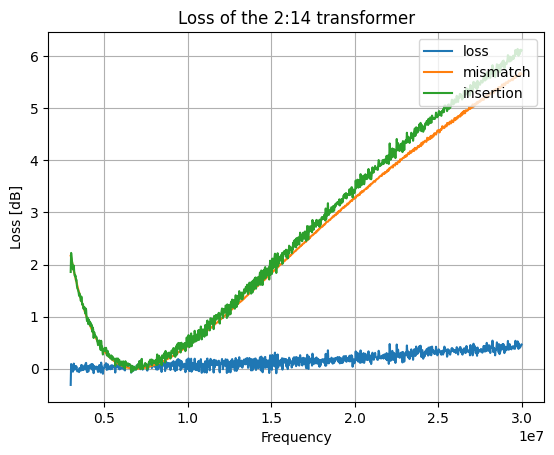

In [7]:
import skrf as rf
from plotResults import plot_s_parameters, plot_transformer_loss

nw = rf.Network('./measurements/SIFERRIT/SIFERRIT_2p14s_2400ohm.s2p')
nw_cal = rf.Network('./measurements/SIFERRIT/SIFERRIT_cal_2400ohm.s2p')
plot_s_parameters(nw)
loss_db = plot_transformer_loss(nw, nw_cal, 'Loss of the 2:14 transformer')

## Efficiency

This plot shows how much of the energy goes up into heat.

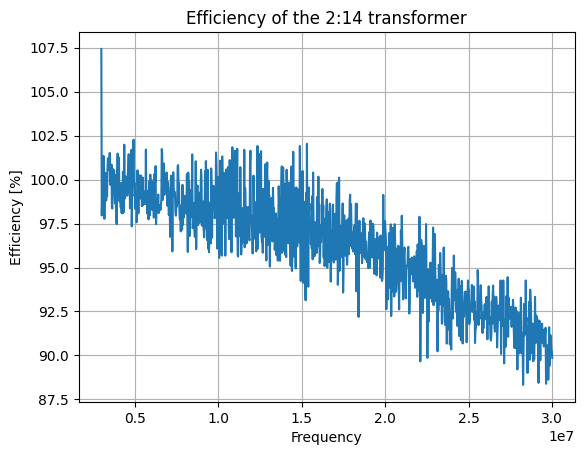

In [8]:
from plotResults import plot_efficiency

nw = rf.Network('./measurements/SIFERRIT/SIFERRIT_2p14s_2400ohm.s2p')
plot_efficiency(nw.f, loss_db,'Efficiency of the 2:14 transformer')

## Conclusion

The insertion loss (or the total of all the losses in the system) is 6dB at 30MHz.  That is another way of saying that at 30MHz we would only get 25% of the input power at the output.  So this is certainly not a great idea.

The measurement results show us that the mismatch loss accounts for most of the loss in the system.

This transformer is much more suited for use between 5MHz and 10MHz.

# 1:7 Configuration

## Measurement 1

* 489kHz measurement frequency
* Zopen = 1.37m + 1.18j Ω
* Zshorted = 2.63m + 125mj Ω

SRF = 2.415e+07Hz and the resistance is 529.6Ω
Leakage inductance = 4.07e-08H
Magnetization inductance = 3.43e-07H
Al = 85.8 nH/N²
Cw = 1.27e-10 F
Low frequency cut-off (fl) = 2.32e+07Hz
High frequency cut-off due to winding capacitance = 2.52e+07Hz
High frequency cut-off due to resonance of winding capacitance and leakage inductance = 7.01e+07Hz


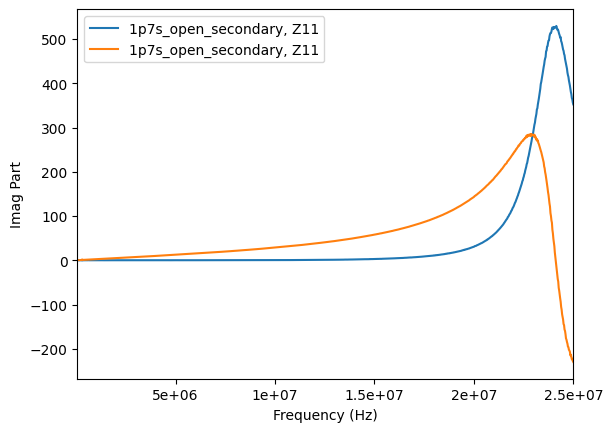

In [9]:
import skrf as rf
import math
import matplotlib.pyplot as plt
import numpy as np
from calcInductors import calcSRF, transformer_bandwidth_calculation

Zopen = 1.37e-3 + 1.18j
Zshorted = 2.63e-3 + 125e-3j

nw = rf.Network('./measurements/SIFERRIT/1p7s_open_secondary.s1p')
nw.plot_z_re()
nw.plot_z_im()

srf = calcSRF(nw)
print('SRF = {:.4}Hz and the resistance is {:.4}Ω'.format(srf[1], srf[0]))

transformer_bandwidth_calculation(489e3, srf[1], 2, 50, Zopen, Zshorted)

## Conclusion

Once again, the winding capacitance is quite high.  The Al value seems to be very low.  Probably this single turn primary doesn't couple well enough with the core.

## Measurement 2

/home/christoph/.local/lib/python3.10/site-packages/skrf/mathFunctions.py:265: RuntimeWarning: divide by zero encountered in log10
  out = 20 * npy.log10(z)


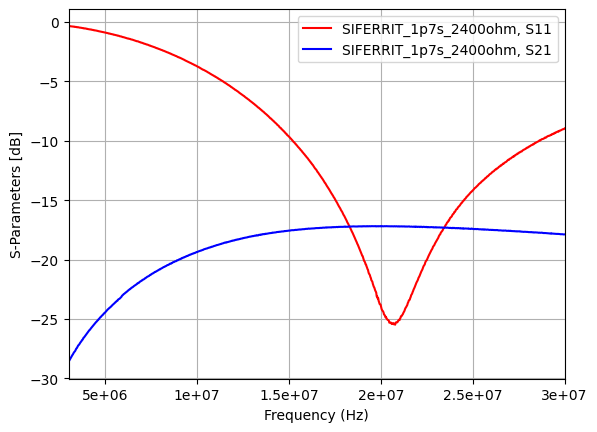

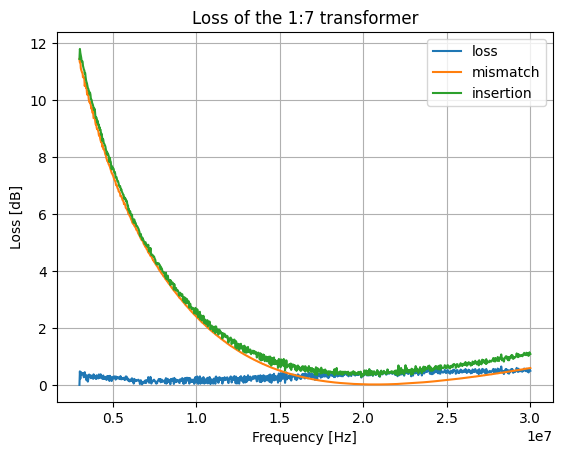

In [1]:
import skrf as rf
from plotResults import plot_s_parameters, plot_transformer_loss

nw = rf.Network('./measurements/SIFERRIT/SIFERRIT_1p7s_2400ohm.s2p')
nw_f1 = nw['3MHz-30MHz']
nw_cal = rf.Network('./measurements/SIFERRIT/SIFERRIT_cal_2400ohm.s2p')
nw_cal_f1 = nw_cal['3MHz-30MHz']
plot_s_parameters(nw_f1)
loss_db = plot_transformer_loss(nw_f1, nw_cal_f1, 'Loss of the 1:7 transformer')

## Conclusion

The 1:7 transformer is suitable for the 15MHz to 30MHz frequencies.